<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/VAE%E7%94%9F%E6%88%90%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 変分オートエンコーダ (VAE) 異常検知 — 再構成誤差 vs 潜在距離（可視化付き）
# - ConvVAE を正常データのみ（1つの MNIST 数字）で学習
# - スコア:
#   (1) 再構成誤差 (BCE または MSE)  ← 推奨: MNIST では BCE
#   (2) 潜在マハラノビス距離（train-normal の z_mu にガウスをフィット, LedoitWolf 使用）
#   (3) 融合スコア = alpha*再構成 + (1-alpha)*潜在
# - しきい値:
#   - 再構成: 検証用正常データの分位点
#   - 潜在: カイ二乗理論（自由度=zdim, 上側 p%）※近似。fallback は分位点
# - 可視化: しきい値付きヒストグラム、ROC 曲線、潜在 2D 散布図、ギャラリー
#
#注意事項:
# - SCORE_TYPE='{SCORE_TYPE}' → MNIST には BCE が適しています（Sigmoid 出力・Bernoulli 仮定）。
# - 学習損失 = 再構成 + β・KL。KL の重みはウォームアップ（最初の {KL_WARMUP_EPOCHS} エポックで線形に {BETA} まで増加）。
# - 再構成しきい値 = 検証用正常データにおける p パーセンタイル（VAL_SPLIT={VAL_SPLIT}）。
# - 潜在しきい値 = sqrt(chi2.ppf(p, df=Z_DIM))（SciPy が利用可能な場合）、利用できない場合は分位点。
# - 性能が低い場合: EPOCHS を増やす、Z_DIM（32–64）を調整する、NORMAL_DIGIT を変更する、または ALPHA_FUSE を調整してください。

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

In [5]:
# sklearn / scipy（未インストールならインストール）
try:
    from sklearn.covariance import LedoitWolf
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
    from sklearn.decomposition import PCA
    from scipy.stats import chi2
    SCIPY_OK = True
except Exception:
    import subprocess; subprocess.call(["pip","-q","install","scikit-learn","scipy"])
    from sklearn.covariance import LedoitWolf
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
    from sklearn.decomposition import PCA
    try:
        from scipy.stats import chi2
        SCIPY_OK = True
    except Exception:
        SCIPY_OK = False

In [6]:
# ===== 設定 =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH = 128
EPOCHS = 15
LR = 1e-3
BETA = 1.0                  # β-VAE の β
KL_WARMUP_EPOCHS = 5        # KL の線形ウォームアップ
NORMAL_DIGIT = 1            # 「正常」とみなす数字（0-9）
VAL_SPLIT = 0.1             # train-normal → 検証（再構成しきい値用）に回す割合
SCORE_TYPE = "bce"          # "bce"（MNIST 向け）または "mse"
Z_DIM = 32                  # 潜在次元
THRESH_PCT = 99.0           # 分位点 / 上側確率
ALPHA_FUSE = 0.5            # 融合スコアの重み
SAMPLE_PER_CLASS = 2000     # 散布図用サンプル数
N_VIZ = 8                   # ギャラリーの表示数

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

In [7]:
# ===== データ =====
tfm = transforms.Compose([transforms.ToTensor()])
root = "/content/data"
tr = datasets.MNIST(root, train=True,  download=True, transform=tfm)
te = datasets.MNIST(root, train=False, download=True, transform=tfm)

tr_norm = [i for i,(_,y) in enumerate(tr) if y == NORMAL_DIGIT]
te_norm = [i for i,(_,y) in enumerate(te) if y == NORMAL_DIGIT]
te_anom = [i for i,(_,y) in enumerate(te) if y != NORMAL_DIGIT]

# train-normal を bank(train) / val(threshold) に分割
rng = np.random.default_rng(SEED); rng.shuffle(tr_norm)
n_val = max(1, int(len(tr_norm)*VAL_SPLIT))
val_idx, bank_idx = tr_norm[:n_val], tr_norm[n_val:]

ds_bank = Subset(tr, bank_idx)
ds_val  = Subset(tr, val_idx)
ds_tn   = Subset(te, te_norm)
ds_ta   = Subset(te, te_anom)

def mk_loader(ds, shuffle=False, bs=BATCH):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2,
                      pin_memory=(DEVICE=="cuda"))

ld_bank = mk_loader(ds_bank, shuffle=True)
ld_val  = mk_loader(ds_val)
ld_tn   = mk_loader(ds_tn)
ld_ta   = mk_loader(ds_ta)
print(f"[DATA] normal={NORMAL_DIGIT} | bank={len(ds_bank)} val={len(ds_val)} "
      f"test_norm={len(ds_tn)} test_anom={len(ds_ta)}")


[DATA] normal=1 | bank=6068 val=674 test_norm=1135 test_anom=8865


In [9]:
# ===== モデル: ConvVAE（潜在 z = Z_DIM） =====
class ConvVAE(nn.Module):
    def __init__(self, zdim=32):
        super().__init__()
        # エンコーダ 28 -> 14 -> 7
        self.e1 = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 28->14
        )
        self.e2 = nn.Sequential(
            nn.Conv2d(32,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 14->7
        )
        self.fc_mu     = nn.Linear(64*7*7, zdim)
        self.fc_logvar = nn.Linear(64*7*7, zdim)
        # デコーダ 7 -> 14 -> 28
        self.fc_up = nn.Linear(zdim, 64*7*7)
        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True)  # 14x14
        )
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32,16,3,1,1), nn.ReLU(True),
            nn.Conv2d(16,1,3,1,1), nn.Sigmoid()    # Bernoulli を想定した [0,1] 出力
        )
    def encode(self, x, return_mid=False):
        h1 = self.e1(x)                       # [B,32,14,14]
        h2 = self.e2(h1)                      # [B,64,7,7]
        flat = h2.flatten(1)
        mu = self.fc_mu(flat)                 # [B, zdim]
        logvar = self.fc_logvar(flat)         # [B, zdim]
        if return_mid:
            return mu, logvar, h2
        return mu, logvar
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std                 # サンプリング z
    def decode(self, z):
        h = self.fc_up(z).view(-1,64,7,7)
        h = self.d1(h)
        return self.d2(h)
    def forward(self, x):
        mu, logvar, mid = self.encode(x, return_mid=True)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, z, mu, logvar, mid

vae = ConvVAE(zdim=Z_DIM).to(DEVICE)
opt = torch.optim.Adam(vae.parameters(), lr=LR)

In [10]:
# ===== 学習（正常データのみ）— recon + β·KL =====
def kl_divergence(mu, logvar):
    # KL(q(z|x) || N(0, I)) をサンプルごとに計算
    return 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, dim=1)

vae.train()
for ep in range(1, EPOCHS+1):
    tot = 0.0; n = 0
    kl_w = BETA * min(1.0, ep / max(1, KL_WARMUP_EPOCHS))  # KL の線形ウォームアップ
    for x,_ in ld_bank:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, z, mu, logvar, _ = vae(x)
        if SCORE_TYPE.lower() == "bce":
            recon = F.binary_cross_entropy(x_hat, x, reduction="none").flatten(1).mean(1)
        else:
            recon = F.mse_loss(x_hat, x, reduction="none").flatten(1).mean(1)
        kl = kl_divergence(mu, logvar)
        loss = (recon + kl_w * kl).mean()
        opt.zero_grad(); loss.backward(); opt.step()
        bs = x.size(0); tot += float(loss)*bs; n += bs
    print(f"Epoch {ep:02d}/{EPOCHS}  loss={tot/max(1,n):.6f}  (KL_w={kl_w:.2f})")
vae.eval()

/tmp/ipython-input-1374132972.py:20: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  bs = x.size(0); tot += float(loss)*bs; n += bs


Epoch 01/15  loss=0.318087  (KL_w=0.20)
Epoch 02/15  loss=0.152766  (KL_w=0.40)
Epoch 03/15  loss=0.139379  (KL_w=0.60)
Epoch 04/15  loss=0.134030  (KL_w=0.80)
Epoch 05/15  loss=0.129502  (KL_w=1.00)
Epoch 06/15  loss=0.127827  (KL_w=1.00)
Epoch 07/15  loss=0.127392  (KL_w=1.00)
Epoch 08/15  loss=0.126569  (KL_w=1.00)
Epoch 09/15  loss=0.126475  (KL_w=1.00)
Epoch 10/15  loss=0.126355  (KL_w=1.00)
Epoch 11/15  loss=0.126178  (KL_w=1.00)
Epoch 12/15  loss=0.126064  (KL_w=1.00)
Epoch 13/15  loss=0.125750  (KL_w=1.00)
Epoch 14/15  loss=0.125847  (KL_w=1.00)
Epoch 15/15  loss=0.125769  (KL_w=1.00)


ConvVAE(
  (e1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_mu): Linear(in_features=3136, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=32, bias=True)
  (fc_up): Linear(in_features=32, out_features=3136, bias=True)
  (d1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace

In [11]:
# ===== スコア計算ユーティリティ =====
@torch.no_grad()
def recon_scores_and_zmu(loader):
    scores, Xs, Xh, ZMU = [], [], [], []
    for x,_ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, z, mu, logvar, _ = vae(x)
        if SCORE_TYPE.lower() == "bce":
            s = F.binary_cross_entropy(x_hat, x, reduction="none").flatten(1).mean(1)
        else:
            s = F.mse_loss(x_hat, x, reduction="none").flatten(1).mean(1)
        scores.append(s.cpu().numpy())
        Xs.append(x.cpu()); Xh.append(x_hat.cpu()); ZMU.append(mu.cpu().numpy())  # z_mu を保存
    return np.concatenate(scores), torch.cat(Xs,0), torch.cat(Xh,0), np.concatenate(ZMU,0)

print("Scoring ...")
S_val,  Xv, Xv_hat, Zmu_val = recon_scores_and_zmu(ld_val)   # 正常のみ（再構成しきい値用）
S_tn,   Xn, Xn_hat, Zmu_tn  = recon_scores_and_zmu(ld_tn)
S_ta,   Xa, Xa_hat, Zmu_ta  = recon_scores_and_zmu(ld_ta)

# --- 再構成しきい値（検証用正常データの分位点） ---
thr_recon = np.percentile(S_val, THRESH_PCT)

# --- 潜在マハラノビス（train-normal の z_mu にフィット） ---
Zmu_bank = []
with torch.no_grad():
    for x,_ in ld_bank:
        x = x.to(DEVICE)
        _, _, mu_b, logvar_b, _ = vae(x)
        Zmu_bank.append(mu_b.cpu().numpy())
Zmu_bank = np.concatenate(Zmu_bank, 0)
mu_z = Zmu_bank.mean(axis=0)
cov_z = LedoitWolf().fit(Zmu_bank - mu_z).covariance_
Si_z = np.linalg.inv(cov_z + 1e-6*np.eye(cov_z.shape[0]))

def maha_lat(Z):
    d = Z - mu_z
    m2 = np.einsum("nd,dd,nd->n", d, Si_z, d)
    return np.sqrt(np.maximum(m2, 0.0))

M_val = maha_lat(Zmu_val)
M_tn  = maha_lat(Zmu_tn)
M_ta  = maha_lat(Zmu_ta)

# --- 潜在しきい値: カイ二乗（自由度=Z_DIM）の上側 p%、SciPy 不可なら分位点 ---
if SCIPY_OK:
    thr_lat = np.sqrt(chi2.ppf(THRESH_PCT/100.0, df=Z_DIM))
else:
    thr_lat = np.percentile(M_val, THRESH_PCT)

# --- 融合スコア ---
scores_tn = ALPHA_FUSE*S_tn + (1-ALPHA_FUSE)*M_tn
scores_ta = ALPHA_FUSE*S_ta + (1-ALPHA_FUSE)*M_ta

Scoring ...


In [12]:
# ===== 指標 =====
labels = np.concatenate([np.zeros_like(S_tn), np.ones_like(S_ta)])

def eval_scores(name, s_n, s_a, thr=None):
    s = np.concatenate([s_n, s_a])
    auc_v = roc_auc_score(labels, s)
    ap_v  = average_precision_score(labels, s)
    if thr is not None:
        pred = (s >= thr).astype(int)
        acc  = (pred == labels).mean()
        print(f"[{name}] AUC={auc_v:.4f}, AP={ap_v:.4f}, Acc@thr={acc:.4f}, thr={thr:.4f}")
    else:
        print(f"[{name}] AUC={auc_v:.4f}, AP={ap_v:.4f}")
    return s

S_all_recon = eval_scores(f"Reconstruction({SCORE_TYPE.upper()})", S_tn, S_ta, thr=thr_recon)
S_all_lat   = eval_scores("Latent Mahalanobis", M_tn, M_ta, thr=thr_lat)
S_all_fuse  = eval_scores(f"Fused alpha={ALPHA_FUSE}", scores_tn, scores_ta, thr=None)

[Reconstruction(BCE)] AUC=0.9927, AP=0.9989, Acc@thr=0.8669, thr=0.2983
[Latent Mahalanobis] AUC=0.9318, AP=0.9884, Acc@thr=0.1135, thr=7.3134
[Fused alpha=0.5] AUC=0.9458, AP=0.9909


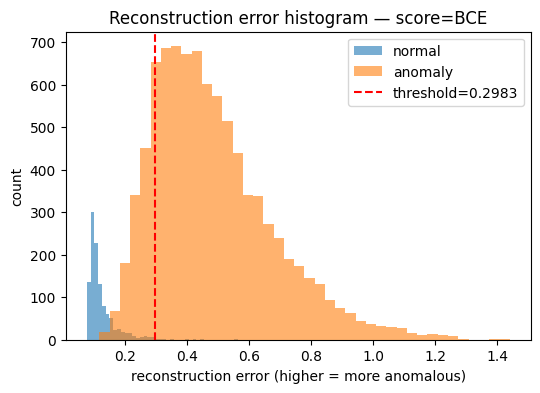

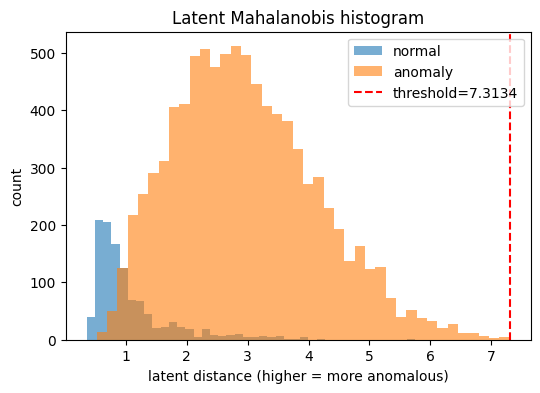

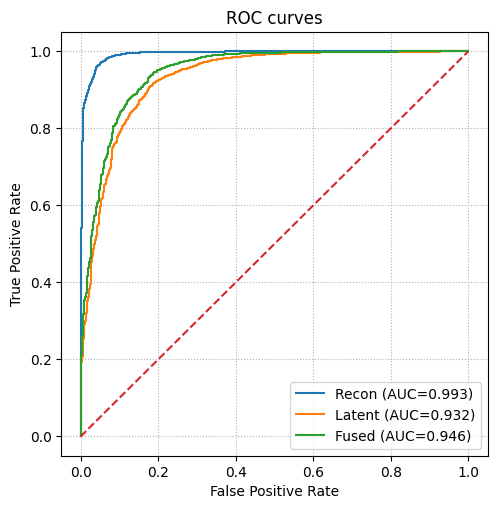

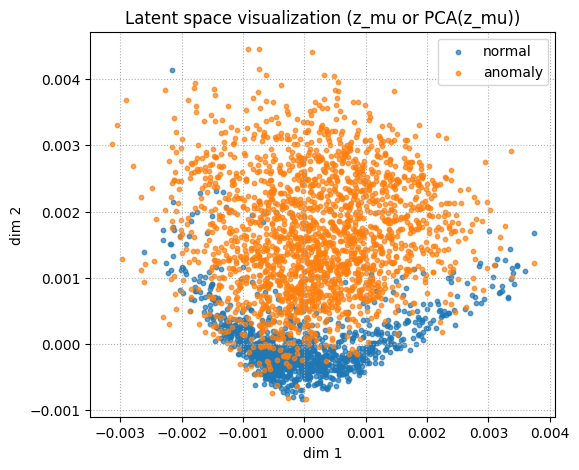

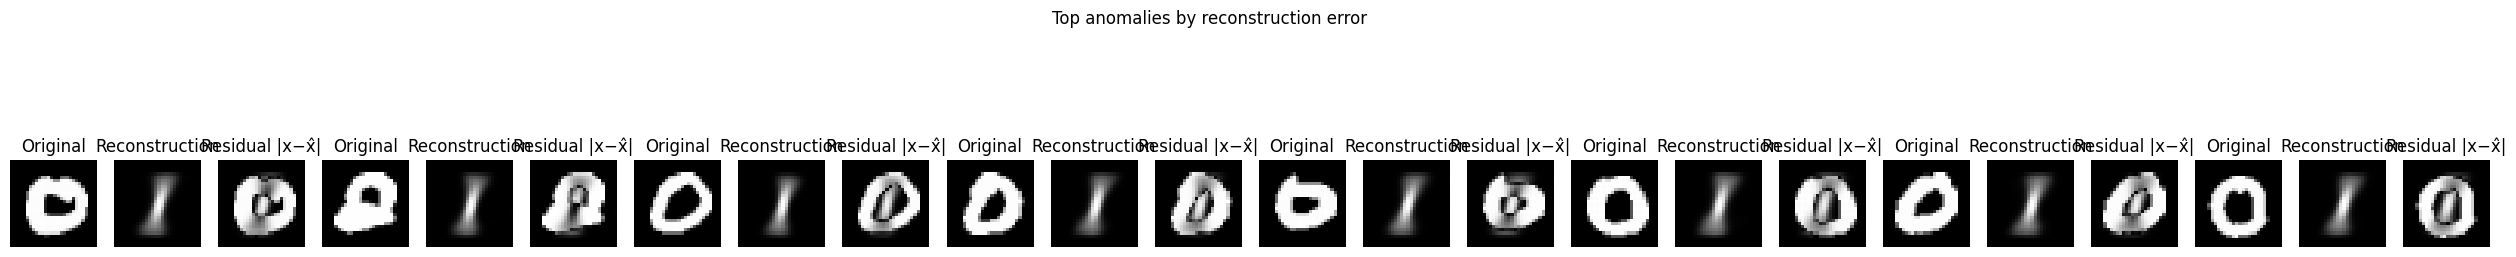

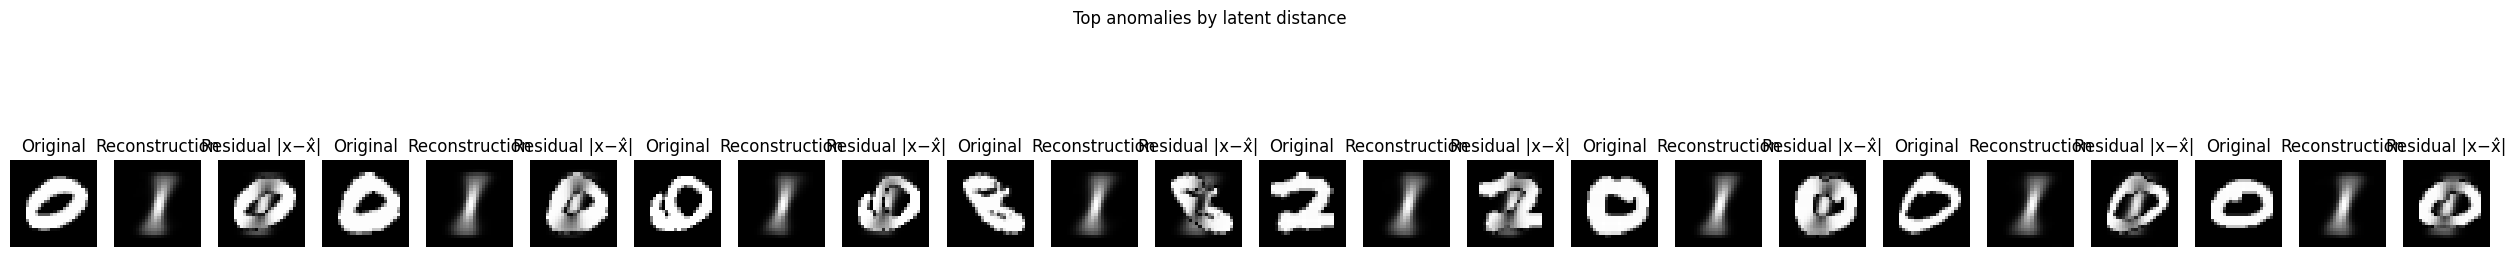

In [13]:


# ===== 可視化 =====
def sample_idx(n_total, n_pick):
    if n_total <= n_pick: return np.arange(n_total)
    return np.random.default_rng(SEED).choice(n_total, size=n_pick, replace=False)

# 1) しきい値付きヒストグラム
plt.figure(figsize=(6,4))
plt.hist(S_tn, bins=40, alpha=0.6, label="normal")
plt.hist(S_ta, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr_recon, linestyle="--", color="red", label=f"threshold={thr_recon:.4f}")
plt.title(f"Reconstruction error histogram — score={SCORE_TYPE.upper()}")
plt.xlabel("reconstruction error (higher = more anomalous)"); plt.ylabel("count"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(M_tn, bins=40, alpha=0.6, label="normal")
plt.hist(M_ta, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr_lat, linestyle="--", color="red", label=f"threshold={thr_lat:.4f}")
plt.title("Latent Mahalanobis histogram")
plt.xlabel("latent distance (higher = more anomalous)"); plt.ylabel("count"); plt.legend(); plt.show()

# 2) ROC 曲線（Recon / Latent / Fused）
fpr_r, tpr_r, _ = roc_curve(labels, S_all_recon)
fpr_m, tpr_m, _ = roc_curve(labels, S_all_lat)
fpr_f, tpr_f, _ = roc_curve(labels, S_all_fuse)
plt.figure(figsize=(5.5,5.5))
plt.plot(fpr_r, tpr_r, label=f"Recon (AUC={auc(fpr_r,tpr_r):.3f})")
plt.plot(fpr_m, tpr_m, label=f"Latent (AUC={auc(fpr_m,tpr_m):.3f})")
plt.plot(fpr_f, tpr_f, label=f"Fused (AUC={auc(fpr_f,tpr_f):.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curves"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True, linestyle=":"); plt.show()

# 3) 潜在空間の 2D 可視化（z_mu または PCA(z_mu)）
pca_z = PCA(n_components=2, random_state=SEED).fit(Zmu_bank)
Zn2 = pca_z.transform(Zmu_tn)
Za2 = pca_z.transform(Zmu_ta)
Zn2_s = Zn2[sample_idx(len(Zn2), SAMPLE_PER_CLASS)]
Za2_s = Za2[sample_idx(len(Za2), SAMPLE_PER_CLASS)]
plt.figure(figsize=(6,5))
plt.scatter(Zn2_s[:,0], Zn2_s[:,1], s=10, alpha=0.7, label="normal")
plt.scatter(Za2_s[:,0], Za2_s[:,1], s=10, alpha=0.7, label="anomaly")
plt.title("Latent space visualization (z_mu or PCA(z_mu))")
plt.xlabel("dim 1"); plt.ylabel("dim 2"); plt.legend(); plt.grid(True, linestyle=":"); plt.show()

# 4) ギャラリー: 再構成誤差・潜在距離の上位異常
def show_gallery(X, Xhat, title, n=N_VIZ):
    X = X[:n]; Xhat = Xhat[:n]; resid = (X - Xhat).abs()
    plt.figure(figsize=(4*n, 4))
    for i in range(min(n, X.shape[0])):
        plt.subplot(1, 3*n, 3*i+1); plt.imshow(X[i,0], cmap="gray"); plt.axis("off"); plt.title("Original")
        plt.subplot(1, 3*n, 3*i+2); plt.imshow(Xhat[i,0], cmap="gray"); plt.axis("off"); plt.title("Reconstruction")
        plt.subplot(1, 3*n, 3*i+3); plt.imshow(resid[i,0], cmap="gray"); plt.axis("off"); plt.title("Residual |x−x̂|")
    plt.suptitle(title); plt.show()

k = min(N_VIZ, len(S_ta))
top_recon = torch.topk(torch.from_numpy(S_ta), k=k).indices
show_gallery(Xa[top_recon], Xa_hat[top_recon], "Top anomalies by reconstruction error")

top_lat = torch.topk(torch.from_numpy(M_ta), k=k).indices
show_gallery(Xa[top_lat], Xa_hat[top_lat], "Top anomalies by latent distance")


